# Imports and seed setting

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime
from einops.layers.torch import Rearrange
import time
from datagen import gen_data



# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Setting training data directory and parameters for training

In [3]:
# Define the dataset of images
img_dataset = "DRIVE"

# Define data rotation of the read data
data_rotation = 3

# Define the runs it needs to do
runs = []
runs.append({'dataset': 'DRIVE', 'data_rotation': data_rotation, 'model': 'original'})

# Root directory for dataset
data_dir = gen_data(runs[0])
dataroot = os.path.join(data_dir, "training", "images")
dataroot_vessels = os.path.join(data_dir, "training", "1st_manual")

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 640 #640 is big no no for me
patch_size = 64
num_patches = image_size // patch_size

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 10

# Number of growing epochs
num_growing_epochs = 4

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

data for dataset DRIVE with rotation 3 already exists


torch.Size([2, 3, 640, 640])


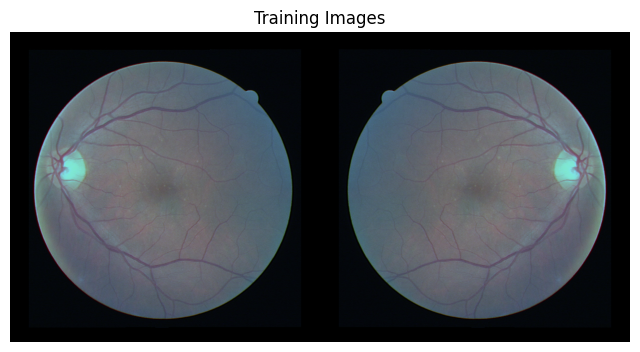

In [4]:
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_pre_norm = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
dataloader_pre_norm = torch.utils.data.DataLoader(dataset_pre_norm, batch_size=batch_size, shuffle=False, num_workers=workers)
mean, std = get_mean_and_std(dataloader_pre_norm)
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

torch.Size([2, 1, 640, 640])


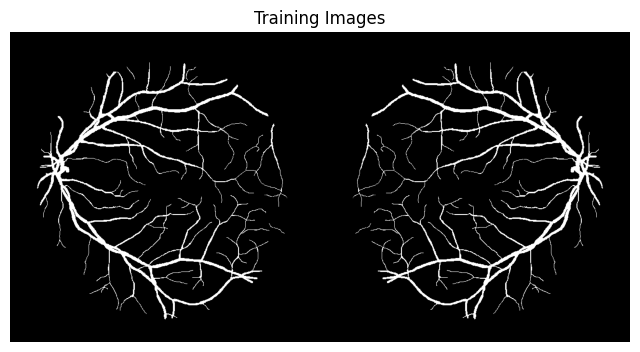

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset_vessels = dset.ImageFolder(root=dataroot_vessels,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))
# Create the dataloader
dataloader_vessels = torch.utils.data.DataLoader(dataset_vessels, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)


# Plot some training images
real_batch_vessels = next(iter(dataloader_vessels))
print(real_batch_vessels[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch_vessels[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Implementation and creation of the generator

## Original

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        """
        generate network based on unet
        """
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        # set image specifics
        k = 3  # kernel size
        self.s = 2  # stride
        img_ch = 3  # image channels
        out_ch = 1  # output channel
        padding = 'same'
        self.conv1 = nn.Sequential(
            nn.Conv2d(nc, ngf, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=k,stride=(self.s,self.s), padding = 1)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(ngf, ngf * 2, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=k,stride=(self.s,self.s), padding = 1)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=k,stride=(self.s,self.s), padding = 1)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(ngf * 4, ngf * 8, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=k,stride=(self.s,self.s), padding = 1)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(ngf * 8, ngf * 16,kernel_size=k, padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.Conv2d(ngf * 16, ngf * 16, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(ngf * (16+8), ngf * 8, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Conv2d(ngf * 8, ngf * 8, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(ngf * (8+4), ngf * 4, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(ngf * (4+2), ngf * 2, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(ngf * (2+1), ngf, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf, kernel_size=(k,k), padding=padding, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        self.outputs = nn.Sequential(
            nn.Conv2d(ngf, out_ch, kernel_size=(1,1), padding=padding),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        #print("generator")
        #print("input:", input.shape)
        
        out1 = self.conv1(input)
        pool1 = self.pool1(out1)
        #print(out1.shape)
        
        out2 = self.conv2(pool1)
        pool2 = self.pool2(out2)
        #print(out2.shape)
        
        out3 = self.conv3(pool2)
        pool3 = self.pool3(out3)
        #print(out3.shape)
        
        out4 = self.conv4(pool3)
        pool4 = self.pool4(out4)
        #print(out4.shape)
        
        out5 = self.conv5(pool4)
        #print(out5.shape)
        out6 = self.conv6(torch.cat([nn.Upsample(scale_factor=self.s)(out5), out4], dim=1))
        out7 = self.conv7(torch.cat([nn.Upsample(scale_factor=self.s)(out6), out3], dim=1))
        out8 = self.conv8(torch.cat([nn.Upsample(scale_factor=self.s)(out7), out2], dim=1))
        out9 = self.conv9(torch.cat([nn.Upsample(scale_factor=self.s)(out8), out1], dim=1))
        out10 = self.outputs(out9)
        return out10

In [8]:
# Generator Code

class Generator_Patch(nn.Module):
    def __init__(self, ngpu):
        super(Generator_Patch, self).__init__()
        self.ngpu = ngpu
        self.patchify = Rearrange('b c (h p1) (w p2) -> (b h w) c p1 p2',
                        p1 = patch_size,
                        p2 = patch_size)
        self.conv1 = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False), # out: ngf x 32 x 32
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            # input is ``(ngf) x 32 x 32``
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False), # out: ngf*2 x 16 x 16 
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            # input is ``(ngf*3) x 32 x 32``
            nn.ConvTranspose2d(ngf * 3, ngf * 4, 4, 2, 1, bias=False), # out: ngf*4 x 64 x 64
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # input is ``(ngf*4) x 64 x 64``
            nn.ConvTranspose2d(ngf * 4, 1, 5, 1, 2, bias=False), # out: 1 x 64 x 64
            nn.Tanh()
        )
        self.combine = Rearrange('(b n m) c p1 p2 -> b c (n p1) (m p2)',
                    p1 = patch_size,
                    p2 = patch_size,
                    n = num_patches,
                    m = num_patches)
        
    def forward(self, input):
        patches = self.patchify(input)
        out1 = self.conv1(patches)
        out2 = self.conv2(out1)
        out3 = self.conv3(torch.cat([nn.Upsample(scale_factor=2)(out2), out1], dim=1))
        return self.combine(out3)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size

# Implementation and creation of the discriminator

## Original

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        """
        generate network based on unet
        """
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        # set image specifics
        k = 3  # kernel size
        s = 2  # stride
        img_ch = 3  # image channels
        out_ch = 1  # output channel
        padding = 'same'
        self.conv4 = nn.Sequential(
            nn.Conv2d(nc, ndf, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf),
            nn.ReLU(True),
            nn.Conv2d(ndf, ndf * 2, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=k,stride=s)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(ndf * 2,ndf * 4, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
            nn.Conv2d(ndf * 4, ndf * 8, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.ReLU(True),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(ndf * 16, ndf * 32, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 32),
            nn.ReLU(True),
            nn.Conv2d(ndf * 32, ndf * 64, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 64),
            nn.ReLU(True),
        )
        self.outputs = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Linear(1,1)
        )
        
    def forward(self, input):
        out1 = self.conv4(input),
        out2 = self.conv5(out1),
        out3 = self.conv6(out2),
        out4 = self.outputs(out3)
        return out4

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        """
        generate network based on unet
        """
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        # set image specifics
        k = 3  # kernel size
        s = 2  # stride
        img_ch = 3  # image channels
        out_ch = 1  # output channel
        padding = 'same'
        self.conv1 = nn.Sequential(
            nn.Conv2d(nc+1, ndf, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf),
            nn.ReLU(True),
            nn.Conv2d(ndf, ndf, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=k,stride=s, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.ReLU(True),
            nn.Conv2d(ndf*2, ndf*2, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=k,stride=s, padding=1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*4),
            nn.ReLU(True),
            nn.Conv2d(ndf*4, ndf*4, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*4),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=k,stride=s, padding=1)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*8),
            nn.ReLU(True),
            nn.Conv2d(ndf*8, ndf*8, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf*8),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=k,stride=s, padding=1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(ndf * 8,ndf * 16, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.ReLU(True),
            nn.Conv2d(ndf * 16, ndf * 16, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.ReLU(True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(ndf * 16,ndf * 16, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.ReLU(True),
            nn.Conv2d(ndf * 16, ndf * 16, k, padding=padding, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.ReLU(True),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dense = nn.Linear(ndf * 16,1)
        self.sigmoid = nn.Sigmoid()
        #self.outputs = nn.Sequential(
        #    nn.AdaptiveAvgPool2d(1),
        #    nn.Linear(ndf * 16,1)
        #)
        
    def forward(self, input):
        #print("forward discriminator")
        #print(input.shape)
        out1 = self.conv1(input)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)
        out6 = self.conv6(out5)
        #out7 = self.outputs(out6)
        out7 = self.pool(out6)
        #print(out7.shape)
        out7 = out7.squeeze((2,3))
        #print(out7.shape)
        out8 = self.dense(out7)
        #print(out8.shape)
        #out9 = out8.unsqueeze(2).unsqueeze(3)
        return self.sigmoid(out8)

In [11]:
class Discriminator_Patch(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_Patch, self).__init__()
        self.ngpu = ngpu
        self.patchify = Rearrange('b c (h p1) (w p2) -> (b h w) c p1 p2',
                        p1 = patch_size,
                        p2 = patch_size,
                        c = nc + 1)
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.combine = nn.Sequential(
            Rearrange('(b n m) 1 1 1 -> b (n m) 1 1',
                    n = num_patches,
                    m = num_patches),
            nn.Conv2d(num_patches**2, 1, 1, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        print("forward discriminator patch")
        print(input.shape)
        patches = self.patchify(input)
        print(patches.shape)
        out = self.main(patches)
        out2 = self.combine(out)
        print(out2.shape)
        return out2

In [12]:
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, 

# Initialization of loss function
Here we use BCELoss

In [13]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = real_batch[0].to(device)[:4]

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [14]:
def print_time(text):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(text, "Current Time", current_time)  

In [ ]:
datasets_combined = list()
for idx in range(len(dataset)):
    img1, _ = dataset[idx]
    img2, _ = dataset_vessels[idx]
    datasets_combined.append((torch.cat([img1, img2], dim=0),_))
    

In [ ]:
# Load the combined dataset into the dataloader
dataloader_combined = torch.utils.data.DataLoader(datasets_combined, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Get a batch of combined data
real_batch_combined = next(iter(dataloader_combined))
print(real_batch_combined[0].shape)


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
elapsed_times = []

print_time("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    start = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_combined, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)  # TODO: concat real cpu and vessel imgs
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(real_cpu[:,0:3,:,:])
        label.fill_(fake_label)
        fake = torch.cat([real_cpu[:,0:3,:,:], fake], dim=1)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1) # TODO: concat real cpu and vessel imgs
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1) # TODO: concat real cpu and vessel imgs
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu() # TODO: replace noise with test data
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        

        iters += 1
    end = time.time()
    elapsed_times.append(end-start)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Time elapsed during training")
plt.plot(elapsed_times,label="t")

plt.xlabel("iterations")
plt.ylabel("elapsed time")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fundus Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Segmentations")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Save models

In [ ]:
if not os.path.isdir("models"):
    os.makedirs("models")
PATH_GENERATOR = "models/generator_{}_{}_{}_{}.pt".format(num_epochs, image_size, img_dataset, data_rotation)
PATH_DISCRIMINATOR = "models/discriminator_{}_{}_{}_{}.pt".format(num_epochs, image_size, img_dataset, data_rotation)

torch.save(netG.state_dict(), PATH_GENERATOR)
torch.save(netD.state_dict(), PATH_DISCRIMINATOR)

# Loading a models
## Generator

In [22]:
# Create the generator 
netG = Generator(ngpu).to(device)


# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
netG.load_state_dict(torch.load(PATH_GENERATOR))
netG.eval()
print(netG)

Generator(
  (patchify): Rearrange('b c (h p1) (w p2) -> (b h w) c p1 p2', p1=64, p2=64)
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(192, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (4): Tanh()
  )
  (combine): Rearrange('(b n m) c p1 p2 -> b c (n p1) (m p2)', p1=64, p2=64, n=2, m=2)
)


## Discriminator

In [23]:
# Create the discriminator 
netD = Discriminator(ngpu).to(device)


# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.load_state_dict(torch.load(PATH_DISCRIMINATOR))
netD.eval()
print(netG)

Generator(
  (patchify): Rearrange('b c (h p1) (w p2) -> (b h w) c p1 p2', p1=64, p2=64)
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(192, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (4): Tanh()
  )
  (combine): Rearrange('(b n m) c p1 p2 -> b c (n p1) (m p2)', p1=64, p2=64, n=2, m=2)
)
